<a href="https://colab.research.google.com/github/saimasharleen/A-Visual-Search-Engine-for-Image-Retrieval-using-Feature-Distance-Metrics/blob/main/CNNfromscratch_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
import random
from tensorflow.keras.preprocessing import image

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', False if tf.config.list_physical_devices('GPU') == [] else True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.12.0
Is using GPU? False
Num GPUs Available:  0


In [3]:
#connecting Google Drive with Colab
from google.colab import drive
import zipfile
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [5]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # Get class list
        self.data_classes = os.listdir(self.data_path)

        # Init mapping dict
        self.data_mapping = {}

        # Populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.lower().endswith(('.jpg', '.jpeg')):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = c_name

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # Returns a list of image paths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)

In [6]:
class ImageSearchEngine(object):
    def __init__(self, gallery_dataset):
        self.gallery_dataset = gallery_dataset
        self.gallery_images, self.gallery_classes = self.gallery_dataset.get_data_paths()
        self.gallery_features = self.extract_features(self.gallery_images)

    def extract_features(self, images):
        # Extract features from the images (you can use a suitable feature extraction method here)
        features = []
        for img_path in images:
            image = cv2.imread(img_path)
            # Perform feature extraction on the image and obtain the feature vector
            feature = self.extract_feature(image)
            features.append(feature)
        return np.array(features)

    def extract_feature(self, image):
        # Implement your feature extraction method here
        # This is just a placeholder, replace it with your actual feature extraction code
        return np.random.randn(100)  # Dummy feature vector of size 100

    def search(self, query_image, top_k=5):
        query_feature = self.extract_feature(query_image)
        distances = pairwise_distances(query_feature.reshape(1, -1), self.gallery_features, metric='euclidean')
        sorted_indices = np.argsort(distances)
        top_k_indices = sorted_indices[0][:top_k]
        top_k_images = [self.gallery_images[i] for i in top_k_indices]
        top_k_classes = [self.gallery_classes[i] for i in top_k_indices]
        return top_k_images, top_k_classes

In [7]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # Get class list
        self.data_classes = os.listdir(self.data_path)

        # Init mapping dict
        self.data_mapping = {}

        # Populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            if os.path.isdir(temp_path):  # Check if it's a directory
                temp_images = os.listdir(temp_path)

                for i in temp_images:
                    img_tmp = os.path.join(temp_path, i)

                    if img_tmp.lower().endswith(('.jpg', '.jpeg')):
                        if c_name == 'distractor':
                            self.data_mapping[img_tmp] = -1
                        else:
                            self.data_mapping[img_tmp] = c_name
            else:  # If it's not a directory, assume individual images in the folder
                img_tmp = temp_path
                if img_tmp.lower().endswith(('.jpg', '.jpeg')):
                    self.data_mapping[img_tmp] = c_name

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()), self.data_path))

    def get_data_paths(self):
        # Returns a list of image paths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


In [8]:
# Set the paths to your data files
data_path = '/content/gdrive/MyDrive/ML/dataset/Data'
training_path = '/content/gdrive/MyDrive/ML/dataset/Data/training'
gallery_path = '/content/gdrive/MyDrive/ML/dataset/Data/gallery'
query_path = '/content/gdrive/MyDrive/ML/dataset/Data/query'
validation_path = '/content/gdrive/MyDrive/ML/dataset/Data/validation'


In [9]:
# Create instances of the Dataset class
training_dataset = Dataset(data_path=training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)


Loaded 2488 from /content/gdrive/MyDrive/ML/dataset/Data/training images
Loaded 21 from /content/gdrive/MyDrive/ML/dataset/Data/gallery images
Loaded 6 from /content/gdrive/MyDrive/ML/dataset/Data/query images


In [10]:
import random

# Specify the data folder path
data_folder = '/content/gdrive/MyDrive/ML/dataset/Data/training'

# Get the list of image paths
image_paths = sorted(list(os.listdir(data_folder)))

# Shuffle the image paths
random.seed(421)
random.shuffle(image_paths)

# Print the shuffled image paths
print("Shuffled Image Paths:")
print(image_paths)
print()

# Assign the shuffled image paths to a variable
shuffled_image_paths = image_paths

# Extract the class names from the shuffled image paths
class_names = [os.path.splitext(filename)[0] for filename in shuffled_image_paths]

# Print the class names
print("Class Names:")
print(class_names)


Shuffled Image Paths:
['Valorie_Brabazon', 'Van_Hilley', 'Ryan_Leaf', 'Viara_Vike-Freiberga', 'Zaini_Abdullah', 'Hugh Jackman', 'lauren_cohan', 'jerry_seinfeld', 'Mike_Johanns', 'dwayne_johnson', 'Zdravko_Mucic', 'Saadi_Gadhafi', 'Yuvraj_Singh', 'Mike_Montgomery', 'Tony_Bennett', 'Ruth_Bader_Ginsburg', 'Eduardo_Chillida', 'Ruth_Stubbs', 'Tori_Amos', 'Yves_Brodeur', 'Mike_Helton', 'Tony_Curtis', 'ben_afflek', 'Will Smith', 'Kate Winslet', 'Eduardo_Fischer', 'Mike_Matthews', 'Vernon_Forrest', 'mindy_kaling', 'Zach_Safrin', 'kate_beckinsale', 'Mike_Sherman', 'Valerie_Thwaites', 'Venus_Williams', 'S_Jayakumar', 'Edward_Egan', 'Ruth_Christofferson', 'Zhang_Wenkang', 'Zach_Parise', 'Zhang_Yimou', 'Torri_Edwards', 'Mike_Holmgren', 'Tora_Takagi', 'Vecdi_Gonul', 'Ruth_Dreifuss', 'Mike_Matheny', 'simon_pegg', 'Sandra Bullock', 'Tony_Blair', 'Ruth_Harlow', 'Sadam_Hassan', 'Edouard_Michelin', 'Tony_Elias', 'Zelma_Novelo', 'Vicente_Fox_de_la_Concha', 'Tony_Fernandes', 'madonna', 'Mike_Martz', 'Zeng

In [11]:
import random
import cv2
import os
import numpy as np

# Specify the data folder path
data_folder = '/content/gdrive/MyDrive/ML/dataset/Data/training'

# Get the list of image paths
image_paths = sorted(list(os.listdir(data_folder)))

# Shuffle the image paths
random.seed(421)
random.shuffle(image_paths)

# Print the shuffled image paths
print("Shuffled Image Paths:")
print(image_paths)
print()

Shuffled Image Paths:
['Valorie_Brabazon', 'Van_Hilley', 'Ryan_Leaf', 'Viara_Vike-Freiberga', 'Zaini_Abdullah', 'Hugh Jackman', 'lauren_cohan', 'jerry_seinfeld', 'Mike_Johanns', 'dwayne_johnson', 'Zdravko_Mucic', 'Saadi_Gadhafi', 'Yuvraj_Singh', 'Mike_Montgomery', 'Tony_Bennett', 'Ruth_Bader_Ginsburg', 'Eduardo_Chillida', 'Ruth_Stubbs', 'Tori_Amos', 'Yves_Brodeur', 'Mike_Helton', 'Tony_Curtis', 'ben_afflek', 'Will Smith', 'Kate Winslet', 'Eduardo_Fischer', 'Mike_Matthews', 'Vernon_Forrest', 'mindy_kaling', 'Zach_Safrin', 'kate_beckinsale', 'Mike_Sherman', 'Valerie_Thwaites', 'Venus_Williams', 'S_Jayakumar', 'Edward_Egan', 'Ruth_Christofferson', 'Zhang_Wenkang', 'Zach_Parise', 'Zhang_Yimou', 'Torri_Edwards', 'Mike_Holmgren', 'Tora_Takagi', 'Vecdi_Gonul', 'Ruth_Dreifuss', 'Mike_Matheny', 'simon_pegg', 'Sandra Bullock', 'Tony_Blair', 'Ruth_Harlow', 'Sadam_Hassan', 'Edouard_Michelin', 'Tony_Elias', 'Zelma_Novelo', 'Vicente_Fox_de_la_Concha', 'Tony_Fernandes', 'madonna', 'Mike_Martz', 'Zeng

In [12]:
import random
import cv2
import os
import numpy as np

# Specify the data folder path
data_folder = '/content/gdrive/MyDrive/ML/dataset/Data/training'

# Get the list of image paths
image_paths = sorted(list(os.listdir(data_folder)))

# Shuffle the image paths
random.seed(421)
random.shuffle(image_paths)

# Print the shuffled image paths
print("Shuffled Image Paths:")
print(image_paths)
print()

# Assign the shuffled image paths to a variable
shuffled_image_paths = image_paths

# Extract the class names from the shuffled image paths
class_names = [os.path.splitext(filename)[0] for filename in shuffled_image_paths]

# Print the class names
print("Class Names:")
print(class_names)
print()

Shuffled Image Paths:
['Valorie_Brabazon', 'Van_Hilley', 'Ryan_Leaf', 'Viara_Vike-Freiberga', 'Zaini_Abdullah', 'Hugh Jackman', 'lauren_cohan', 'jerry_seinfeld', 'Mike_Johanns', 'dwayne_johnson', 'Zdravko_Mucic', 'Saadi_Gadhafi', 'Yuvraj_Singh', 'Mike_Montgomery', 'Tony_Bennett', 'Ruth_Bader_Ginsburg', 'Eduardo_Chillida', 'Ruth_Stubbs', 'Tori_Amos', 'Yves_Brodeur', 'Mike_Helton', 'Tony_Curtis', 'ben_afflek', 'Will Smith', 'Kate Winslet', 'Eduardo_Fischer', 'Mike_Matthews', 'Vernon_Forrest', 'mindy_kaling', 'Zach_Safrin', 'kate_beckinsale', 'Mike_Sherman', 'Valerie_Thwaites', 'Venus_Williams', 'S_Jayakumar', 'Edward_Egan', 'Ruth_Christofferson', 'Zhang_Wenkang', 'Zach_Parise', 'Zhang_Yimou', 'Torri_Edwards', 'Mike_Holmgren', 'Tora_Takagi', 'Vecdi_Gonul', 'Ruth_Dreifuss', 'Mike_Matheny', 'simon_pegg', 'Sandra Bullock', 'Tony_Blair', 'Ruth_Harlow', 'Sadam_Hassan', 'Edouard_Michelin', 'Tony_Elias', 'Zelma_Novelo', 'Vicente_Fox_de_la_Concha', 'Tony_Fernandes', 'madonna', 'Mike_Martz', 'Zeng

In [13]:
import cv2
import os

# Set the path to your training data directory
training_data_dir = "/content/gdrive/MyDrive/ML/dataset/Data/training"

# Initialize empty lists for dataset and labels
dataset = []
labels = []

# Get the list of class subfolders
class_subfolders = os.listdir(training_data_dir)

# Iterate over each class subfolder
for class_name in class_subfolders:
    # Get the list of image paths for the current class
    image_paths = os.listdir(os.path.join(training_data_dir, class_name))
    # Iterate over each image path
    for image_path in image_paths:
      # Check if the current file is an image
      if image_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            # Read the image using OpenCV
            image = cv2.imread(os.path.join(training_data_dir, class_name, image_path))

            # Resize the image to a fixed size of 128x128 pixels
            image = cv2.resize(image, (128, 128))

            # Append the preprocessed image and its class label to their respective lists
            dataset.append(image)
            labels.append(class_name)
        except:
            print(f"Error loading and resizing image {image_path} in class {class_name}")


In [14]:
#Converting to numpay array
dataset = np.array(dataset, dtype="float32") / 255.0
original_labels = np.array(labels)

#Here we are using LabelBinarizer to scale data because it does not need data in integer encoded form first to convert into its respective encoding
lb = LabelBinarizer()
labels = lb.fit_transform(original_labels)

In [15]:
#Splitting dataset into train and test

x_train,x_test,y_train,y_test=train_test_split(dataset,labels,test_size=0.3,random_state=421)

In [16]:
print("Train whole set:")
print(x_train.shape, y_train.shape)
print("Test whole set:")
print(x_test.shape, y_test.shape)

Train whole set:
(1746, 128, 128, 3) (1746, 149)
Test whole set:
(749, 128, 128, 3) (749, 149)


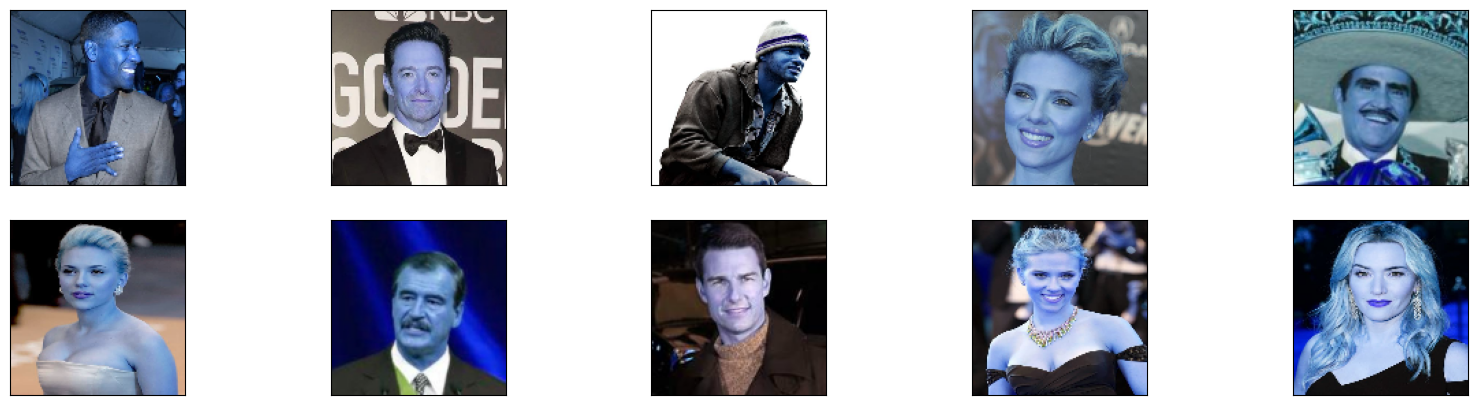

In [17]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(20, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
    plt.show()

show_random_examples(x_train, y_train, y_train)

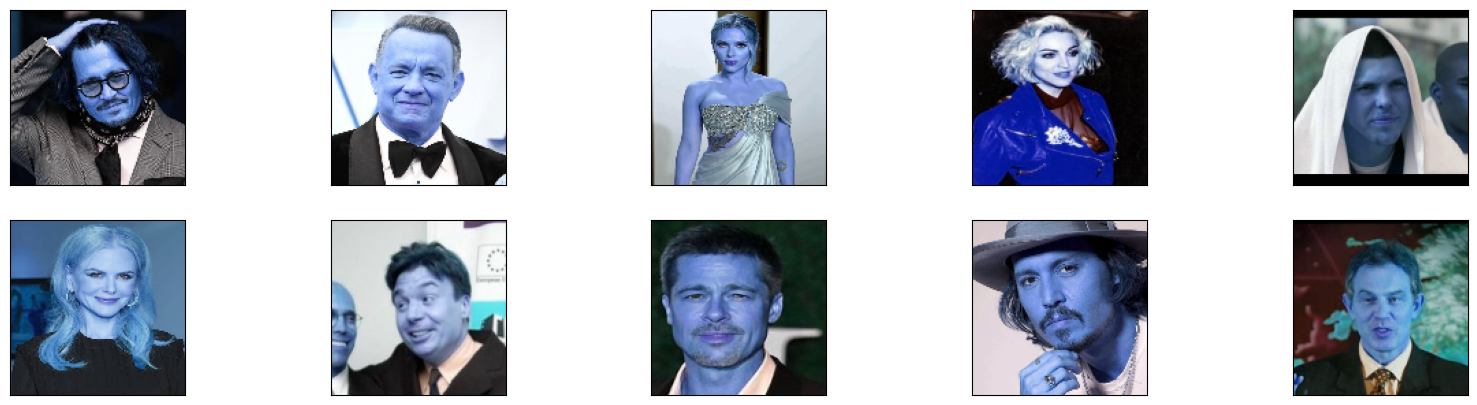

In [18]:
show_random_examples(x_test, y_test, y_test)

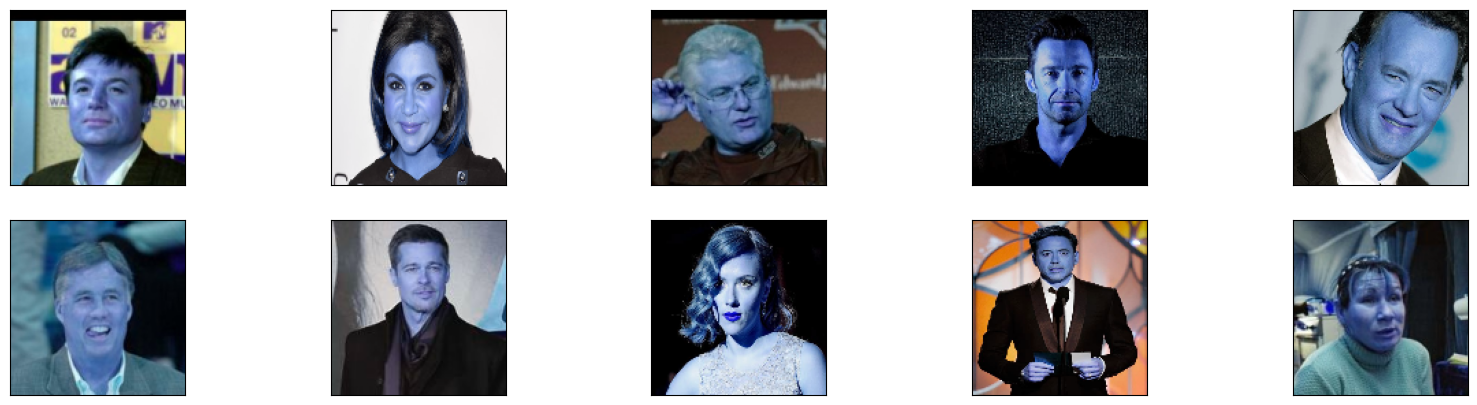

In [19]:
def show_similar_images(x, y, p, specific_class):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        sblabel = i, "pc:"+str(np.argmax(p[i])), "p:"+str(max(p[i])*100)+"%", "tc:"+str(np.argmax(y[i]))
        plt.xlabel(sblabel, color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)


In [20]:
print(np.argmax(y_train[0]))

69


In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
#         model.add(Dropout(0.5))
        return model

    model = tf.keras.models.Sequential()
    model.add(Input(shape=(128, 128,3)))

    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(98, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 64)       2

In [22]:
from keras.utils import to_categorical

# Convert the target labels to one-hot encoding
num_classes = 31
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [23]:
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=4, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)


Epoch 1/4


ValueError: ignored

Resnet50

94765736/94765736 [==============================] - 0s 0us/step
Found 3578 images belonging to 149 classes.
56/56 [==============================] - 589s 10s/step
Num images   =  3578
Shape of feature_list =  (3578, 2048)


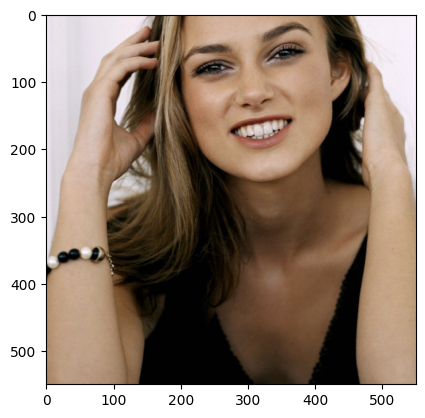

1/1 [==============================] - 0s 146ms/step
[184.11494153 184.88532358 185.4742015  185.4742015  185.86430272]


In [24]:
import os
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
data_path = "/content/gdrive/MyDrive/ML/dataset/Data/training"
batch_size = 64

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(data_path,
                                      target_size=(img_size, img_size),
                                      batch_size=batch_size,
                                      class_mode=None,
                                      shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict(datagen, num_epochs, verbose=1)
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)
# Get full path for all the images in the dataset
filenames = [os.path.join(data_path, s) for s in datagen.filenames]
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)
plt.imshow(plt.imread('/content/gdrive/MyDrive/ML/dataset/Data/query/Test(1).jpg'))
plt.show()
img_path = '/content/gdrive/MyDrive/ML/dataset/Data/query/Test(1).jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)
for dist in _:
    print(dist)

In [25]:
img_path = '/content/gdrive/MyDrive/ML/dataset/Data/query/Test(1).jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

In [26]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

1/1 [==============================] - 0s 132ms/step


In [27]:
for dist in _:
    print(dist)

[184.11494153 184.88532358 185.4742015  185.4742015  185.86430272]


(1, 5)


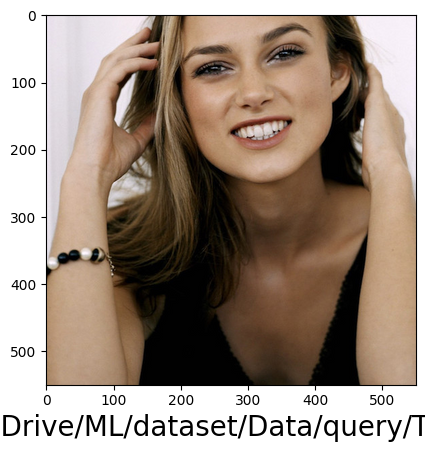

********* Predictions ***********


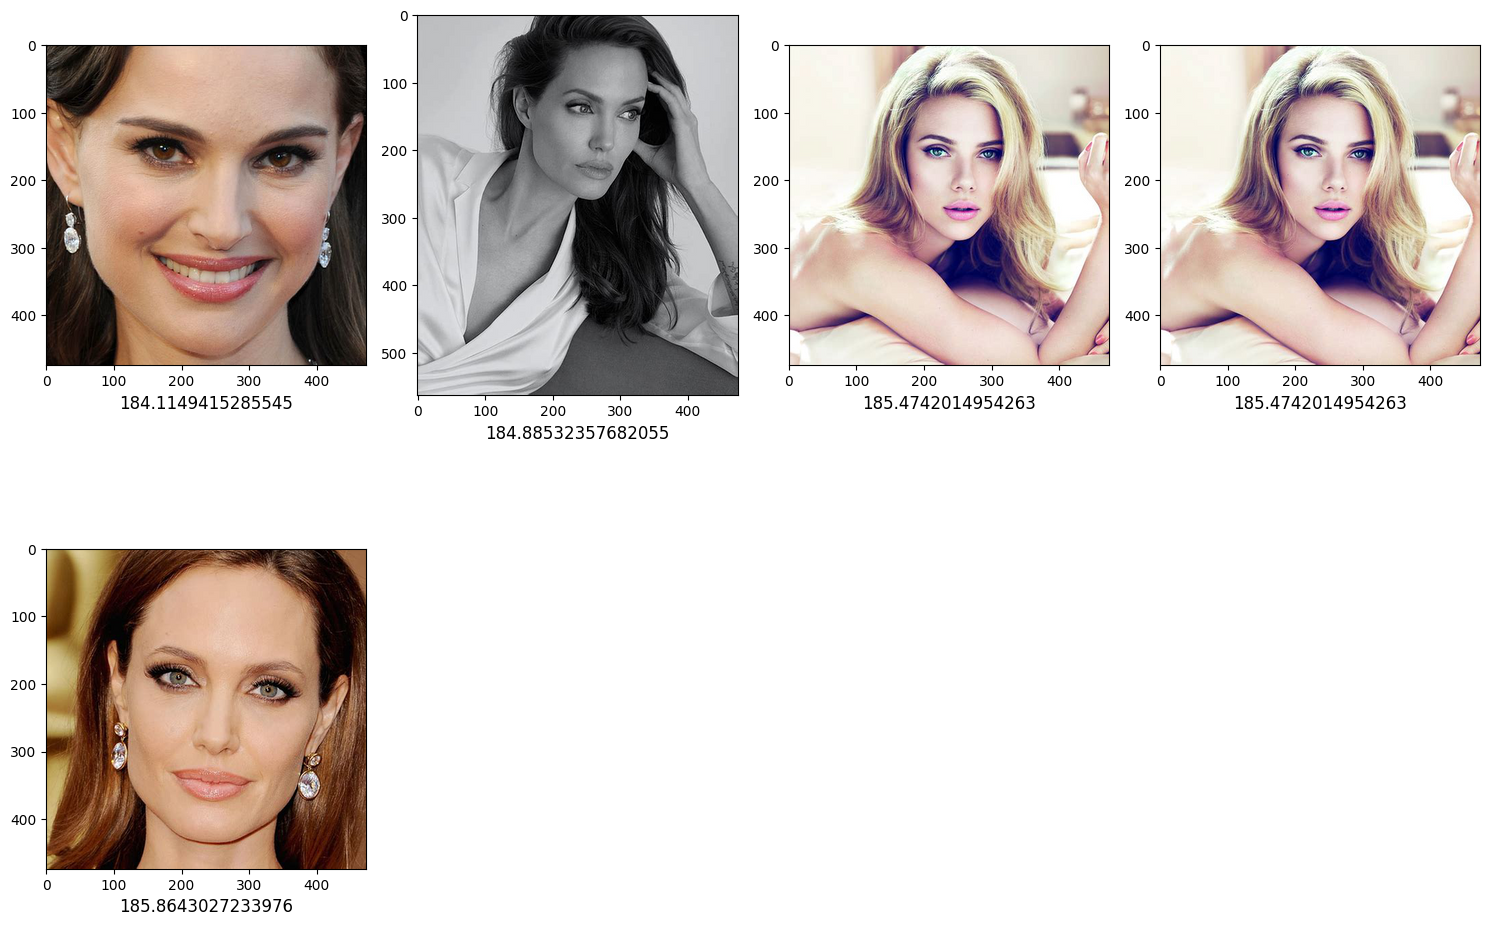

In [28]:
def similar_images(indices, distance):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plt.xlabel(distance[plotnumber-1],fontsize=12)
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0], _[0])

In [29]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [30]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


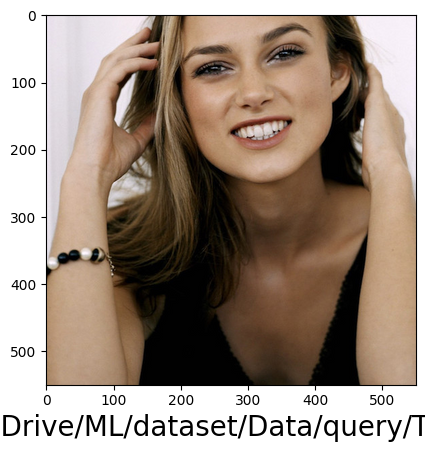

********* Predictions  after PCA ***********


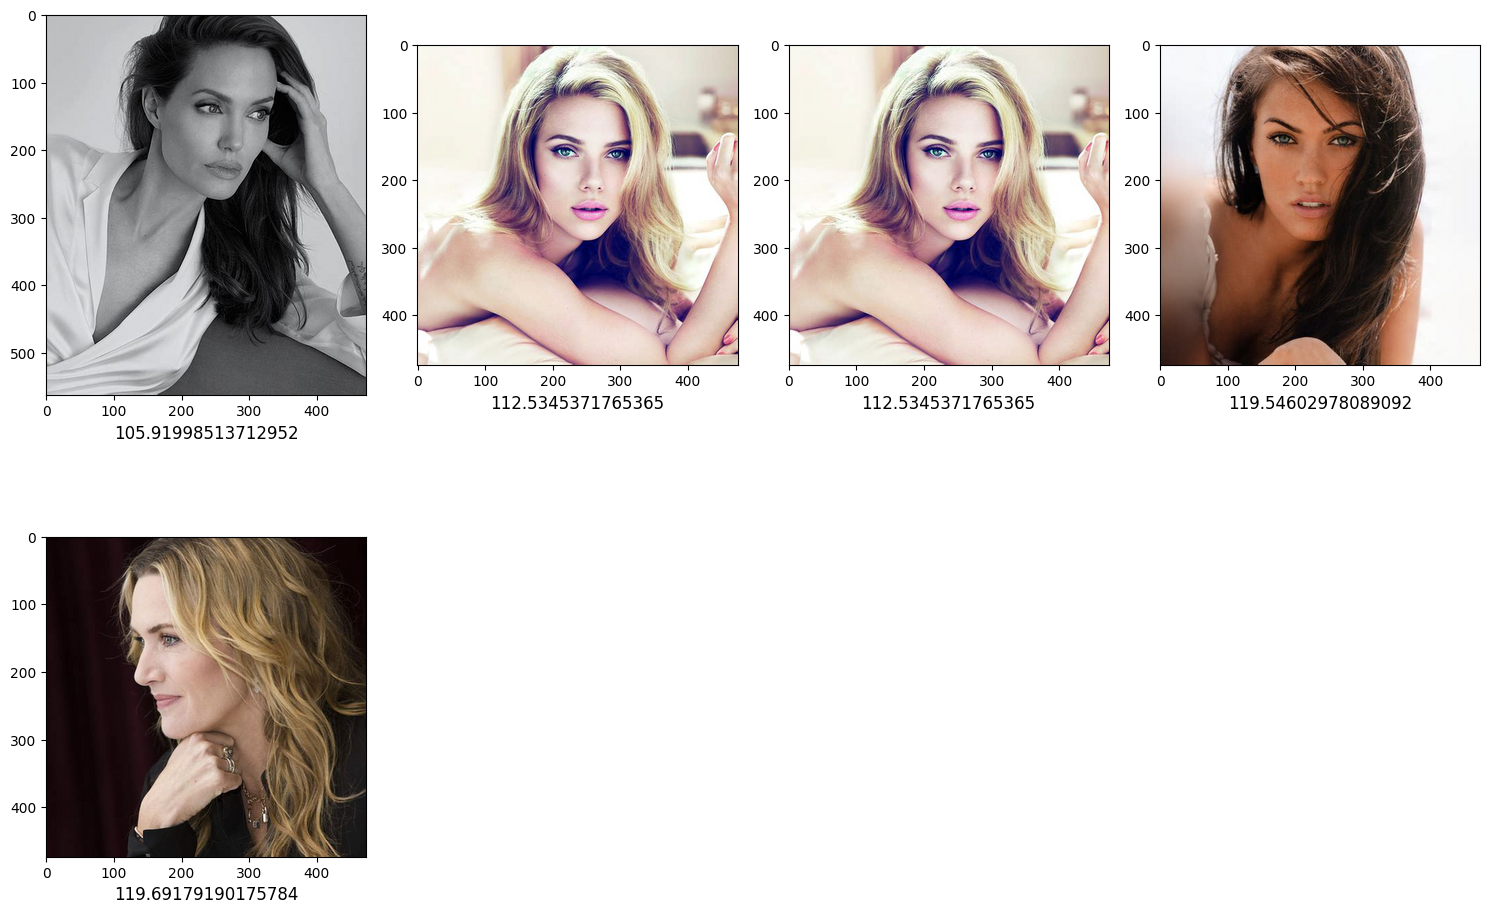

In [31]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions  after PCA ***********')
similar_images(indices[0], distances[0])

VGG16

In [32]:
import tensorflow as tf
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', False if tf.config.list_physical_devices('GPU') == [] else True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.12.0
Is using GPU? False
Num GPUs Available:  0


In [33]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
train_path = '/content/gdrive/MyDrive/ML/dataset/Data/training'
valid_path = '/content/gdrive/MyDrive/ML/dataset/Data/gallery'

In [34]:
# useful for getting number of classes
folders = glob(train_path+'/*')

print(len(folders))

149


In [35]:
# add preprocessing layer to the front of VGG16
vgg16 = tf.keras.applications.VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train resnet50 weights
for layer in vgg16.layers:
  layer.trainable = False

vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [36]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
# Make last 4 layers trainable
model.get_layer('block5_conv3').trainable = True
model.get_layer('block5_conv2').trainable = True
model.get_layer('block5_conv1').trainable = True
model.get_layer('block4_conv3').trainable = True

In [38]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [39]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.3)

# test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset='training')

test_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset='validation')




# training_set,test_set=train_test_split(training_set,test_size=0.3,random_state=421)

Found 2555 images belonging to 149 classes.
Found 1023 images belonging to 149 classes.


In [40]:
from keras.callbacks import LearningRateScheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
# fit the model
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_VGG16_TL_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        ),
        LearningRateScheduler(lr_scheduler, verbose=1)
    ]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
80/80 [==============================] - 1791s 22s/step - loss: 4.1331 - accuracy: 0.0720 - val_loss: 3.4892 - val_accuracy: 0.0909 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/5
51/80 [==================>...........] - ETA: 8:22 - loss: 3.4580 - accuracy: 0.1131